In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2
import shutil
from sklearn.model_selection import train_test_split

In [2]:
os.listdir('/kaggle/input/lung-cancer-dataset-1/Lung Cancer Dataset 1')

['Bengin', 'Normal', 'Malignant']

In [3]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    images={}
    count=0

    for i in range(len(classes)):
        x=""
        if i==0:
          x="Bengin"
        elif i==1:
          x="Malignant"
        elif i==2:
          x="Normal"
        imgs=os.listdir(os.path.join(data_path, x))
        images[i]=imgs
        count+=len(imgs)

    for k, v in images.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return images

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        x=""
        if k==0:
          x="Bengin"
        elif k==1:
          x="Malignant"
        elif k==2:
          x="Normal"
        for i in range(5):
            img_path=os.path.join(data_path, x, v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"{x}")
        plt.show()

In [5]:
class_names=['Bengin', 'Malignant', 'Normal']

In [6]:
base_dir="/kaggle/input/lung-cancer-dataset-1/Lung Cancer Dataset 1"

In [7]:
working_data_path = '/kaggle/working/dataset'

In [8]:
# Copy the dataset to a writable directory
if not os.path.exists(working_data_path):
    shutil.copytree(base_dir, working_data_path)

In [9]:
train_split = '/kaggle/working/dataset/train_split'  # New train data path (70%)
valid_split = '/kaggle/working/dataset/valid_split'  # New validation data path (10%)
test_split = '/kaggle/working/dataset/test_split'  # New test data path (20%)

In [10]:
# Create directories if they don't exist
os.makedirs(train_split, exist_ok=True)
os.makedirs(valid_split, exist_ok=True)
os.makedirs(test_split, exist_ok=True)

categories = os.listdir(base_dir)

In [12]:
# Split and copy data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    
    # Split the images into 70% train and 30% remaining (for test and validation)
    train_images, remaining_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Split remaining images into 2/3 test (20%) and 1/3 validation (10%)
    test_images, valid_images = train_test_split(remaining_images, test_size=1/3, random_state=42)
    
    # Create category subdirectories in the new train and valid directories
    train_category_path = os.path.join(train_split, category)
    test_category_path = os.path.join(test_split, category)
    valid_category_path = os.path.join(valid_split, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(valid_category_path, exist_ok=True)
    
    # Copy images to the respective folders
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))
    for img in valid_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(valid_category_path, img))

print("Data split complete!")

Data split complete!


In [14]:
train_data=get_classes(train_split, class_names, 'Train')
test_data=get_classes(test_split, class_names, 'Test')
valid_data=get_classes(valid_split, class_names, 'Valid')

----Train----
Grade 0-Bengin: 84 images, 10.95%
Grade 1-Malignant: 392 images, 51.11%
Grade 2-Normal: 291 images, 37.94%
----Test----
Grade 0-Bengin: 24 images, 10.96%
Grade 1-Malignant: 112 images, 51.14%
Grade 2-Normal: 83 images, 37.9%
----Valid----
Grade 0-Bengin: 12 images, 10.81%
Grade 1-Malignant: 57 images, 51.35%
Grade 2-Normal: 42 images, 37.84%


Train data-Bengin


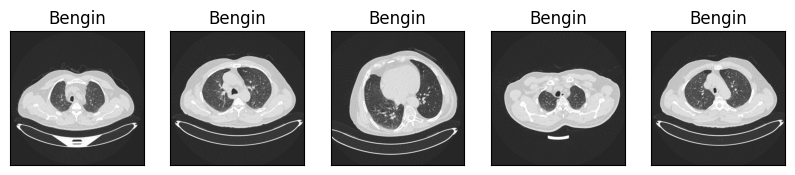

Train data-Malignant


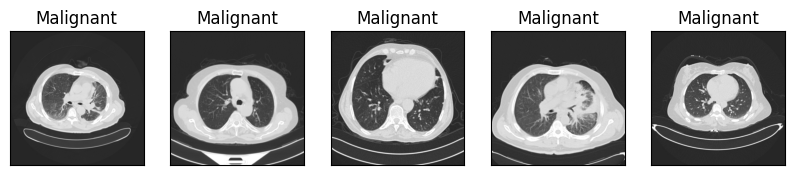

Train data-Normal


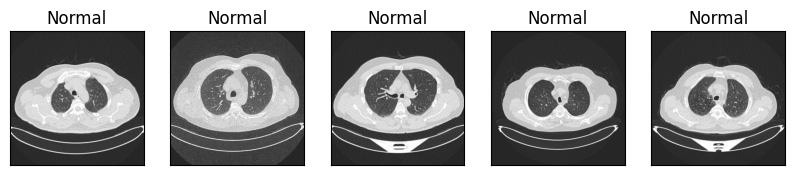

In [15]:
plot_classes(train_data, train_split, class_names, 'Train data')

In [16]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [17]:
model_name="ConvNext"

target_size=(224, 224)
epochs=10
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [18]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.convnext.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.convnext.preprocess_input,
)

Found 767 images belonging to 3 classes.


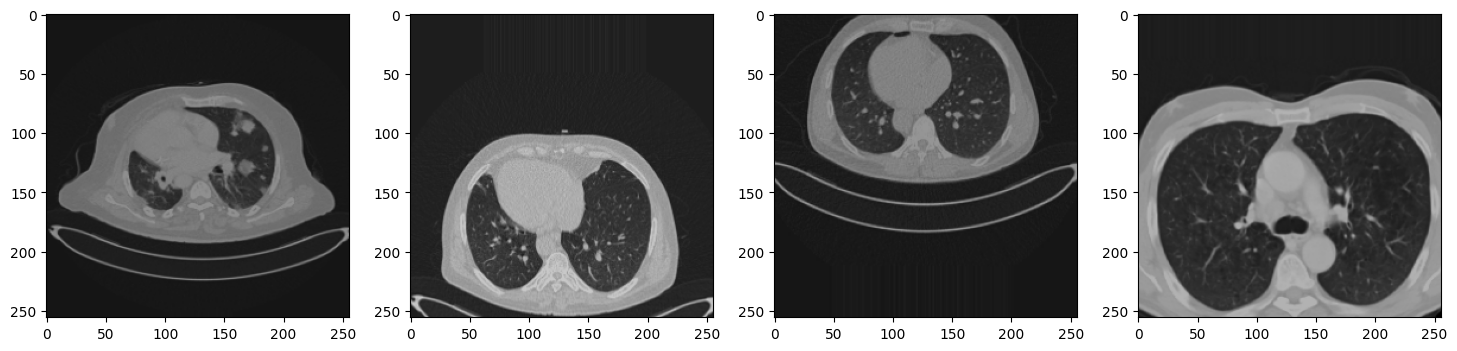

In [19]:
imagegen=aug_datagen.flow_from_directory(train_split, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

In [21]:
train_generator = aug_datagen.flow_from_directory(
    train_split, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_split,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 767 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [22]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 84, 1: 392, 2: 291}
{0: 3.0436507936507935, 1: 0.6522108843537415, 2: 0.8785796105383734}


In [24]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [25]:
model = tf.keras.applications.ConvNeXtSmall(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
m=model.output

In [27]:
m = tf.keras.layers.GlobalAveragePooling2D()(m)
m = tf.keras.layers.Dropout(0.2)(m)

In [32]:
predictions = tf.keras.layers.Dense(3, activation='softmax')(m)

In [33]:
model_ft = tf.keras.models.Model(inputs=model.input, outputs=predictions)
model_ft.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_pre… │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_stem │ (None, 56, 56,    │      4,896 │ convnext_small_p… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │      4,800 │ convnext_small_s… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │        192 │ convnext_small_s… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │     37,248 │ convnext_small_s… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │          0 │ convnext_small_s… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │     36,960 │ convnext_small_s… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │         96 │ convnext_small_s… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │          0 │ convnext_small_s… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ convnext_small_s… │
│                     │ 96)               │            │ convnext_small_s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │        192 │ convnext_small_s… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │     37,248 │ convnext_small_s… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │          0 │ convnext_small_s… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │     36,960 │ convnext_small_s… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 56, 56,    │         96 │ convnext_small_s

 Total params: 49,456,995 (188.66 MB)

 Trainable params: 49,456,995 (188.66 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [35]:
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728458213.812515     865 service.cc:145] XLA service 0x7cf588003ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728458213.812576     865 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728458213.812580     865 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728458233.526619     922 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1728458240.255914  

21/24 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.3457 - loss: 1.4904

I0000 00:00:1728458302.082210     995 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1744 bytes spill stores, 1748 bytes spill loads

I0000 00:00:1728458308.629331     996 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 2464 bytes spill stores, 2468 bytes spill loads

I0000 00:00:1728458309.802223     994 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1728458316.905769     996 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1776 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1728458340.860577     867 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_91', 24 bytes spill stores, 24 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3474 - loss: 1.4713 

I0000 00:00:1728458358.368234    1035 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1728458362.334765    1036 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1744 bytes spill stores, 1748 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.3476 - loss: 1.4660 - val_accuracy: 0.1081 - val_loss: 1.2613
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 746ms/step - accuracy: 0.3574 - loss: 1.2080 - val_accuracy: 0.3784 - val_loss: 1.2411
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 772ms/step - accuracy: 0.3801 - loss: 1.1634 - val_accuracy: 0.2703 - val_loss: 1.7864
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 745ms/step - accuracy: 0.3658 - loss: 1.2351 - val_accuracy: 0.5766 - val_loss: 0.9697
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 776ms/step - accuracy: 0.5595 - loss: 0.9723 - val_accuracy: 0.7117 - val_loss: 0.8254
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 752ms/step - accuracy: 0.6089 - loss: 0.9023 - val_accuracy: 0.5766 - val_loss: 0.5722
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 743ms/step - accuracy: 0.6593 - loss: 0.6000 - val_accuracy: 0.4685 - val_loss: 0.9266
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 755ms/step - accuracy: 0.6454 - loss: 0.6292 - val_accuracy: 0.4595 

In [36]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ConvNext fine tuning executed in 6.95 minutes


In [37]:
model.save('/kaggle/working/ConvNext.h5')

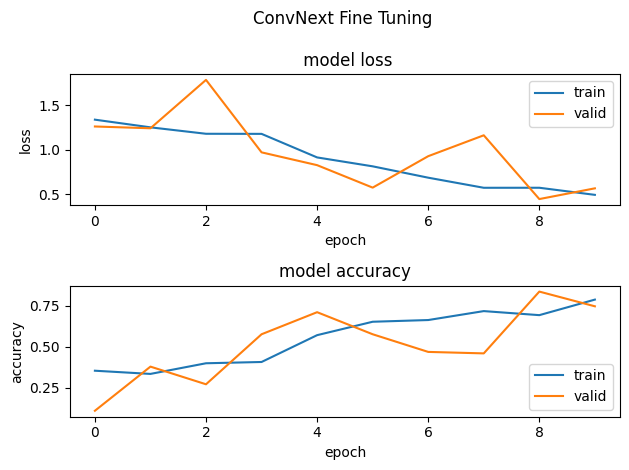

In [38]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [51]:
get_evaluate(train_generator, "Train", model_ft)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - accuracy: 0.7869 - loss: 0.3532
Train loss:  0.36
Train accuracy:  0.78


In [39]:
get_evaluate(valid_generator, "Valid", model_ft)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7866 - loss: 0.5821
Valid loss:  0.56
Valid accuracy:  0.75


In [40]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 
Accuracy Score - ConvNext:  0.75
Balanced Accuracy Score - ConvNext:  0.73


              precision    recall  f1-score   support

           0       0.30      0.75      0.43        12
           1       1.00      0.88      0.93        57
           2       0.77      0.57      0.66        42

    accuracy                           0.75       111
   macro avg       0.69      0.73      0.67       111
weighted avg       0.84      0.75      0.78       111



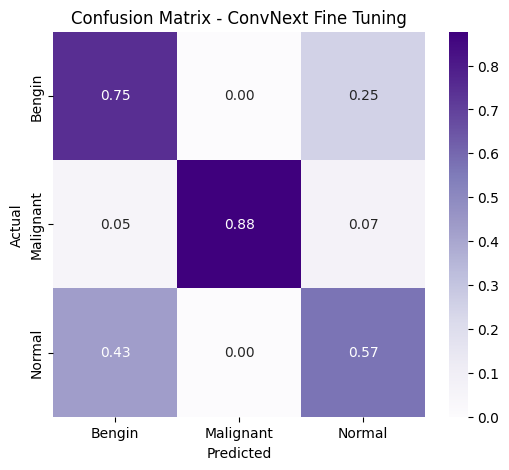

In [41]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [43]:
test_generator = noaug_datagen.flow_from_directory(
    test_split,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 219 images belonging to 3 classes.


In [44]:
ConvNext = model_ft

In [45]:
predictions_convnext = ConvNext.predict(test_generator)
score_convnext = ConvNext.evaluate(test_generator, verbose=1)
print('Test loss:', score_convnext[0])
print('Test acc:', score_convnext[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7169 - loss: 0.6091
Test loss: 0.6091144680976868
Test acc: 0.7168949842453003


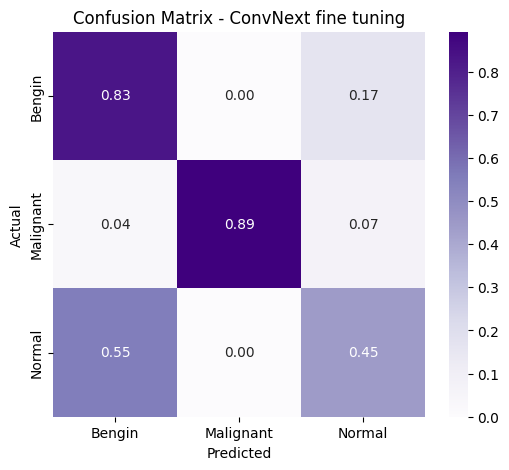

In [47]:
compute_confusion_matrix(
    test_generator,
    predictions_convnext,
    class_names,
    f"{model_name} fine tuning",
)

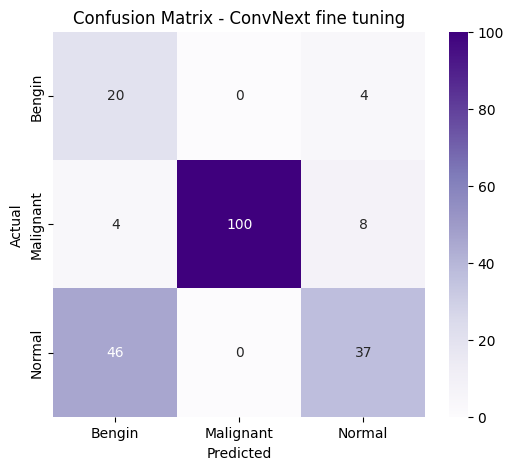

In [48]:
def count_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("int")
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".0f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)
    
count_confusion_matrix(
    test_generator,
    predictions_convnext,
    class_names,
    f"{model_name} fine tuning",
)

In [49]:
results = get_predict(test_generator, ConvNext)

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(results, axis=1),
    model_name=model_name,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
Accuracy Score - ConvNext:  0.72
Balanced Accuracy Score - ConvNext:  0.72


              precision    recall  f1-score   support

           0       0.29      0.83      0.43        24
           1       1.00      0.89      0.94       112
           2       0.76      0.45      0.56        83

    accuracy                           0.72       219
   macro avg       0.68      0.72      0.64       219
weighted avg       0.83      0.72      0.74       219

